# Financial Time Series forecasting using Wavelet Transformation and SVM

## Contents:
* [First part, using SVM + slide window using original time series](#first-part)
    * [Graphical data analysis](#1.2)
    * [SVM + Sliding Window implementation](#1.3)
* [Second part, breaking the time series down into pieces using MODWT](#second-part)
    * [Reconstructing original time series](#2.1)
* [Third part, evaluating Wavelet coefficients using SVR](#third-part)
* [Fourth part, constructing prediction model](#fourth-part)

***
### Description

This is a project based on the article named  "*SVR-Wavelet Adaptive Model for Forecasting Financial Time Series*" found here: https://ieeexplore.ieee.org/document/8356851. 

The data used is the historical currency values for AUD(Australian Dollar) to JPY (Japanese Yen) from: https://www.histdata.com/download-free-forex-historical-data/?/ascii/tick-data-quotes/AUDJPY in the period of 2003-2014, we had to transform the data from 1-minute interval to 1-day interval.

### Metodology

**First**, we evaluate the time series using the SVM without breaking it down into pieces.

**Second**, we break down in pieces the original time series using the maximal overlap discrete wavelet transform(MODWT) with 5 levels, obtaining the approximation coefficients (aC) and the detail coefficients (dC).

**Third**, we take the aC and each level of the dC and we evaluate them using the SVM algorithm using the Radial Basis Function Kernel (rbf). Then, we use the inverse MODWT (imodwt) to reconstruct the time series with the new coefficients from the SVM function. 

**Finally**, we sumarize the method by constructing a prediction model.
***

## IMPLEMENTATION
***

In [59]:
#Standard libraries
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
#Libraries for SVM implementation
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import mean_squared_error
from numpy.lib.stride_tricks import sliding_window_view
#Library for Wavelets transformations, the code was taken from: https://github.com/pistonly/modwtpy/blob/master/modwt.py
from lib.modwt import modwt, modwtmra,imodwt

## First part, using SVM + slide window using original time series <a class="anchor" id="first-part"></a>
***

### Graphical data analysis <a class="anchor" id="1.2"></a>

In [3]:
#Reading the data from csv file
#We use 'parse_dates' to convert the date string into objects we can work with
prices = pd.read_csv('../Data/AUD-JPY-2003-2014-day.csv',delimiter=";", header=0, encoding='utf-8', parse_dates=['Date'])
prices

,Date,Open,High,Low,Close
0,2003-01-01,67.05,67.06,67.05,67.06
1,2003-01-02,67.50,67.50,67.49,67.50
2,2003-01-03,67.98,67.98,67.98,67.98
3,2003-01-05,67.91,67.91,67.90,67.91
4,2003-01-06,68.69,68.69,68.68,68.68
...,...,...,...,...,...
3744,2014-12-26,97.71,97.71,97.68,97.70
3745,2014-12-28,97.82,97.82,97.80,97.80
3746,2014-12-29,97.92,97.93,97.88,97.88
3747,2014-12-30,98.02,98.02,98.01,98.02


In [4]:
# dropping unused columns 
prices.drop(["Open", "High", "Low"],axis = 1, inplace = True)
# defining variables
dates = prices['Date'].copy()
closing_prices = prices['Close'].copy()

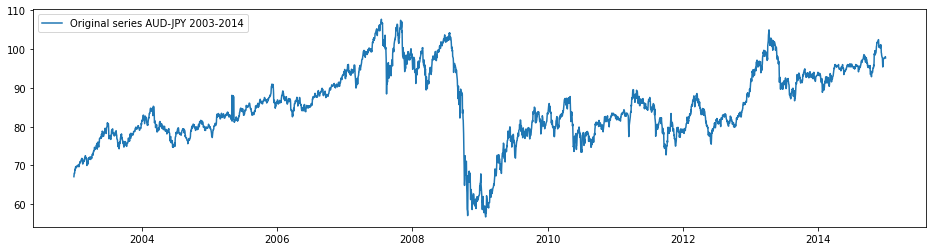

In [5]:
#Plotting the original time series using matplotlib. We are only plotting the 'Date' and 'Close' columns (2D)
plt.subplots(figsize=(16,4))
plt.plot(dates, closing_prices, label='Original series AUD-JPY 2003-2014')
#Legend location
plt.legend(loc = 'best')
plt.show()

### SVM + Sliding Window implementation <a class="anchor" id="1.3"></a>

Defining window lenght: how long back in time we see to predict the current value. E.g. If window_lenght=2, means that we take the two previous values to predict the value in current value. 
Let's say `closing_prices = [ 12, 13, 14 ]`, the sloding window determines that the value in `closing_prices[2] = [14]` is due to the values in `closing_prices[0:2] = [ 12, 13 ]`

In [75]:
#Implementing slide window
def slideWindow(series, window_lenght = 2):

    _X, _Y = [], []
    #Auxiliary variable to store the sliding window combinations. We sum up +1 as we are taking the last values of Aux_window
    #as the output values of our time series
    aux_Window =  sliding_window_view(series, window_lenght+1)
    # Taking first 'window_lenght' values as the input (X) and the last value (window_lenght+1) as the output (Y)
    for i in range(len(aux_Window)):
        _Y.append(aux_Window[i][-1])
        _X.append(aux_Window[i][:-1])
    
    return _X, _Y
window_lenght = 2
#Calling slide window function    
X, Y = slideWindow(closing_prices,window_lenght)
#We store the 'Dates' from the testing data on a separate variable to be able to plot it later
#We are taking the 25% of the dates as later, we take the 25% of the data to test the SVM
idx_test_date = int(0.75*len(Y)) + window_lenght
df = pd.DataFrame(columns = ['test_date']) 
df['test_date'] = prices['Date'].iloc[idx_test_date:]


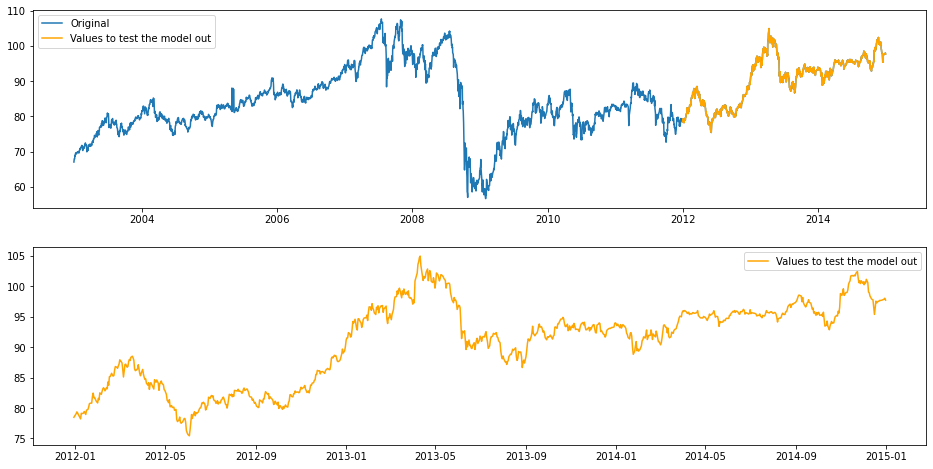

In [36]:
#Splitting and plotting test data

#First we split the data in training data(75%) and test data (25%)
#shuffle = False means that we are not shuffling the data randomly, we want to keep it in order
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.25, random_state=None, shuffle=False)

#We can plot the data to make sure that we are taking the correct values to test out
fig, ax = plt.subplots(2,1,figsize=(16,8))
ax[0].plot(dates, closing_prices, label='Original')
ax[0].plot(df['test_date'], y_test, label='Values to test the model out',color='orange')
ax[1].plot(df['test_date'], y_test, label='Values to test the model out',color='orange')

ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best')
plt.show()

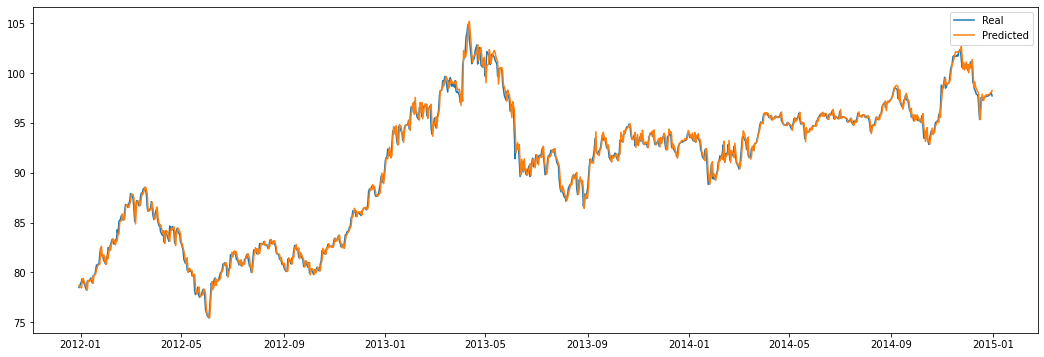

In [60]:
def evaluateSVR(_x_train,_y_train,_x_test,_y_test, kernel = 'rbf'):
    #Implementing SVR
    #We can use multiple kernels to evaluate the model, for this implementation we only use 'rbf'
    #This piece of code was taken from: https://github.com/hanazahrah/Forex-Prediction-using-SVR
    #kernels = ['rbf', 'poly', 'linear']
    if (kernel == 'rbf'):
        clf = svm.SVR(kernel ='rbf', C=1e3, gamma=0.1)
    elif (kernel == 'poly'):
        clf = svm.SVR(kernel ='poly', C=1e3, degree=2)
    else:
        clf = svm.SVR(kernel ='linear',C=1e3)
    _y_predict = clf.fit(_x_train,_y_train).predict(_x_test)
        #print('The RMSE of %s : %f'%(kernel_arg, mean_squared_error(_y_test, _y_predict,squared=False)))        
    
    return _y_predict

y_predict = evaluateSVR(x_train,y_train,x_test,y_test)

#Storing sample to plot later
plotValuesWt = y_test.copy()

#Plotting predicted values
plt.subplots(figsize=(18, 6))
plt.plot(df['test_date'], y_test, label = "Real")
plt.plot(df['test_date'], y_predict, label = "Predicted")
plt.legend(loc = 'best')
plt.show()


## Second part, breaking the time series down into pieces using MODWT <a class="anchor" id="second-part"></a>

(5, 3749)


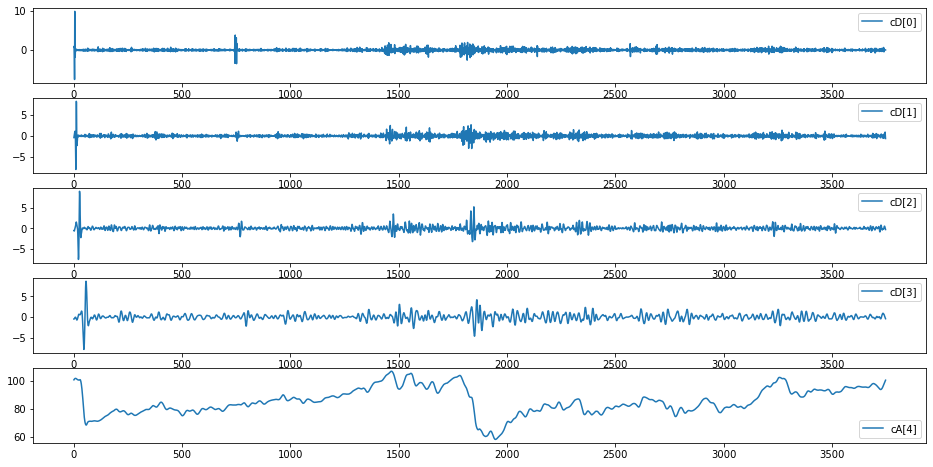

In [12]:
#Using modwt with 'sym4' wavelet and 5 levels (4 detail coffiecients (dC) and 1 approximation coefficient (aC))
def applyModwt(_data, type='sym4', _level=3):
    _coeff = modwt(_data, type, _level)
    return _coeff

#calling function defined previously
level = 4
coeff = applyModwt(closing_prices,type='sym4',_level=level)



#Checking coeff shape, should be an array of len(closing_prices) columns and 5 rows
#where the row number 5  is the row with the approximation coefficients
print(np.shape(coeff))

#We can plot the dC and aC
fig, ax =  plt.subplots(len(coeff), 1, figsize=(16, 8))
for i in range(len(coeff)):
    if i == len(coeff)-1:
        ax[i].plot(coeff[i], label = 'cA[%.0f]'%(i))
        ax[i].legend(loc = 'best')
    else:
        ax[i].plot(coeff[i], label = 'cD[%.0f]'%(i))
        ax[i].legend(loc = 'best')

### Reconstructing original time series <a class="anchor" id="2.1"></a>

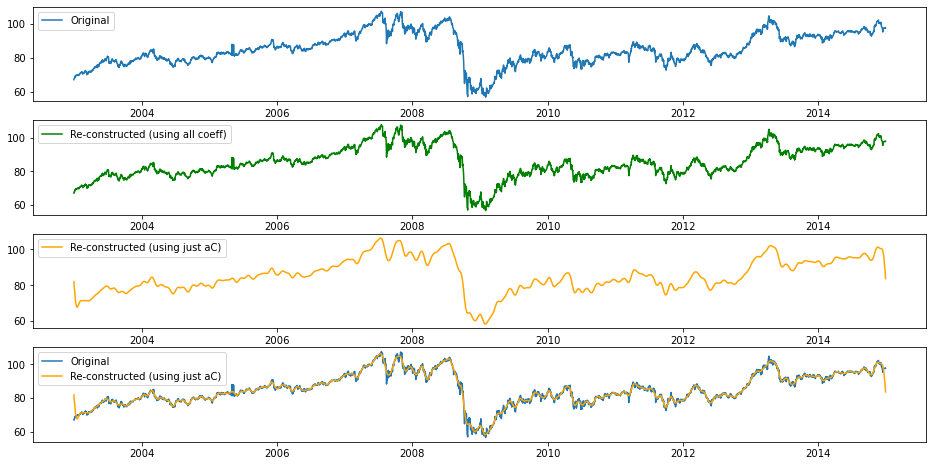

In [13]:
#initialize an array to store the coefficents corresponding to scale 2^4
recwt = np.zeros((np.shape(coeff)[0], np.shape(coeff)[1]))

#Assigning Approximation and Detail Coeficients
aCdC = coeff.copy()

#store coefficents corresponding to scale the 4 of the wavelet transformation
recwt[level:] = coeff[level]

#De-noised financial series. In this case we only use the aC to reconstruct the time series
dFs = imodwt(recwt,'sym4')

#We can also use all de coefficients to re-construct the financial series
rFs = imodwt(coeff,'sym4')

#We can plot to compare
fig, ax = plt.subplots(4,1,figsize=(16,8))
ax[0].plot(dates, closing_prices, label='Original')
#Reconstructed using all dC and aC
ax[1].plot(dates, rFs, label='Re-constructed (using all coeff)', color = 'green')
#Reconstructed using just the aC
ax[2].plot(dates, dFs, label='Re-constructed (using just aC)', color = 'orange')
#Plotting original and de-noised to compare
ax[3].plot(dates, closing_prices, label='Original')
ax[3].plot(dates, dFs, label='Re-constructed (using just aC)', color = 'orange')

ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best')
ax[2].legend(loc = 'best')
ax[3].legend(loc = 'best')

plt.show()


## Third part, evaluating Wavelet coefficients using SVR <a class="anchor" id="third-part"></a>

The RMSE of rbf : 0.153868


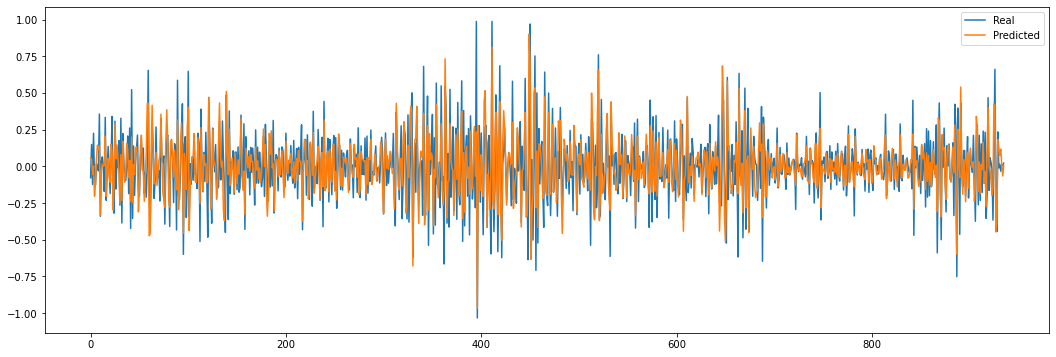

The RMSE of rbf : 0.113081


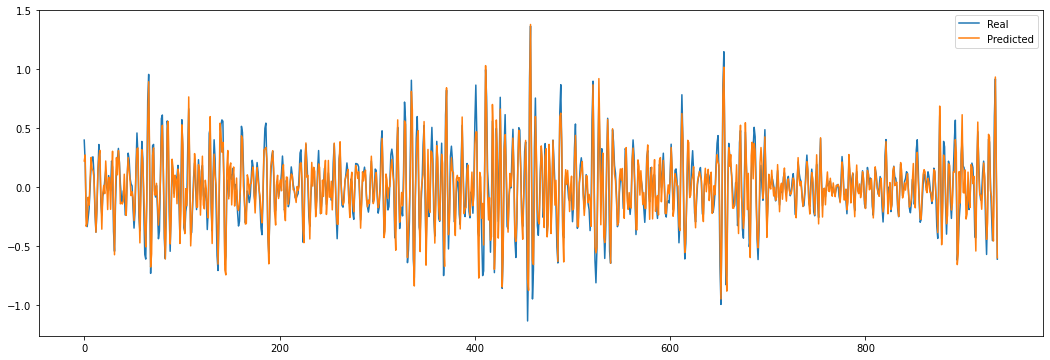

The RMSE of rbf : 0.057634


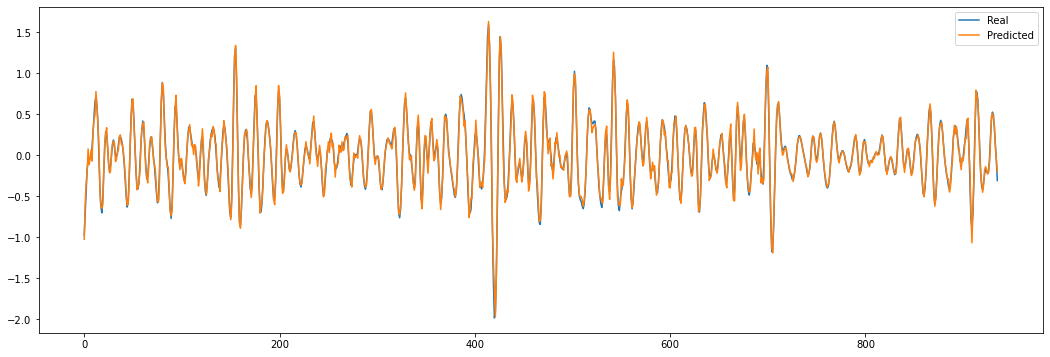

The RMSE of rbf : 0.027402


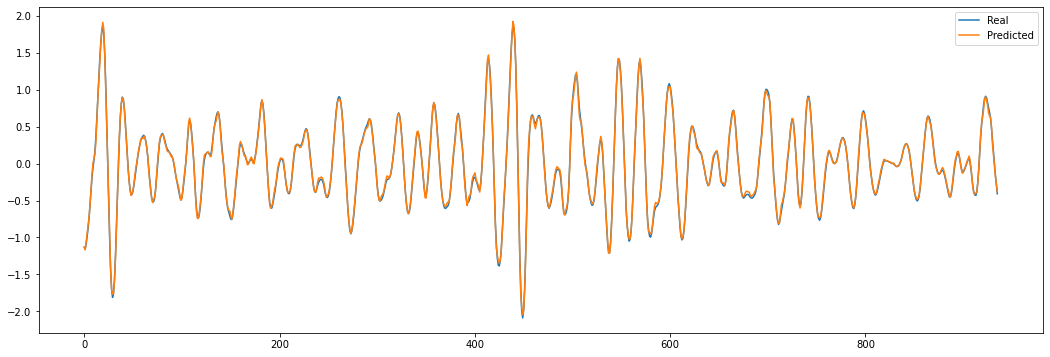

The RMSE of rbf : 0.099891


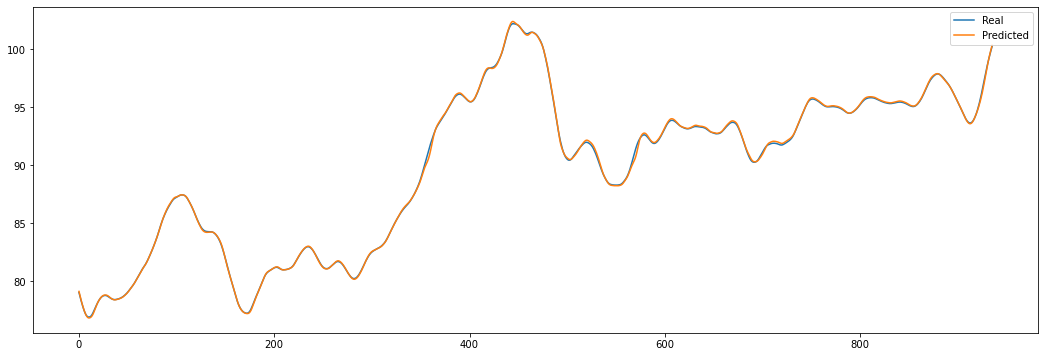

In [14]:
new_coeff = []
#Generating X and Y to evaluate SVR using the slide window
for i in range(len(aCdC)):
    index = int(len(aCdC[i])*0.75)#+ window_lenght
    X, Y = slideWindow(aCdC[i], window_lenght=5)
    #Splitting data
    x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.25, random_state=None, shuffle=False)
    #Evaluating each dC in the SVR function
    y_predict = evaluateSVR(x_train,y_train,x_test,y_test)
    #Storing predicted value and training data to reconstruct the series later 
    new_coeff.append(np.concatenate((aCdC[i][:index], y_predict)))
    #Plotting predicted values per coefficient
    plt.subplots(figsize=(18, 6))
    plt.plot(y_test, label = "Real")
    plt.plot(y_predict, label = "Predicted")
    plt.legend(loc = 'best')
    plt.show()



MSE 0.13004937849142711


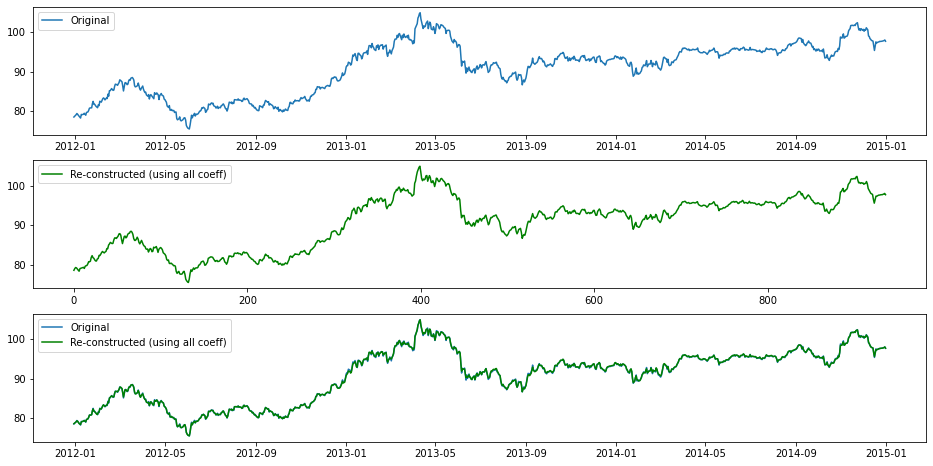

In [17]:
#Plotting new time series using the predicted values
#First, we must inverse the wavelet to create the reconstructed predicted Financial series (rpFS)
rpFs = imodwt(new_coeff,'sym4')

index = int(len(rpFs)*0.75)#+ window_lenght

fig, ax = plt.subplots(3,1,figsize=(16,8))
ax[0].plot(df['test_date'], plotValuesWt, label='Original')
#Reconstructed using all dC and aC
ax[1].plot(rpFs[index:] ,label='Re-constructed (using all coeff)', color = 'green')#df['test_date'], 

ax[2].plot(df['test_date'], plotValuesWt, label='Original')
ax[2].plot(df['test_date'], rpFs[index:] ,label='Re-constructed (using all coeff)', color = 'green')

ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best')
ax[2].legend(loc = 'best')

print('MSE',mean_squared_error(plotValuesWt, rpFs[index:],squared=False))

### Fourth part, constructing prediction model <a class="anchor" id="fourth-part"></a>

### Modelo from the paper (predicting using all coeff) 

In [243]:
def evaluateModel(svr, X, Y, prediction_days, past_days):
    X_ = []
    Y_ = []
    Y_.append(np.array(Y)[-1])
    X_.append(X[-1])
    for i in range(prediction_days):
        Y_array = np.array([Y_[-1]])
        X_array = np.array(X_[-1][-past_days+1:])
        X_Y_concat = np.array([np.concatenate((X_array,Y_array))])
        X_ = np.concatenate(( X_, X_Y_concat ))
        p_value = svr.predict(X_[-1].reshape(1, -1))
        Y_ = np.concatenate(( Y_,  p_value))
    return Y_

In [242]:
#past_days: Defines the number of days in the past to consider to do the prediction
#prediction_days: Defines the number of days in the future to predict
#file_Path: File Path which contains the data
#Delimiter: delimiter to split the data
#dateColName: Date column name
#closingPColName: Closing prices column name
def predictValue(past_days = 7, prediction_days = 5, file_Path = '../Data/AUD-JPY-2003-2014-day.csv', dateColName = 'Date', 
                 closingPColName = 'Close', delimiter = ';'):
    #Getting data from file
    dates, closing_prices = getDatesAndPrices(file_Path, dateColName, closingPColName, delimiter)
    #getting coefficients from Wavelet
    coeff = getCoeffFromSeries(closing_prices)
    
    #Evaluating coefficients using SVR
    predictedCoeff = trainModel(coeff, prediction_days ,past_days)
    return predictedCoeff, dates, closing_prices
    
def getDatesAndPrices(filePath, dateColName, closingPColName, _delimiter):
    #Reading the data from csv file
    #We use 'parse_dates' to convert the date string into objects we can work with
    prices = pd.read_csv(filePath,delimiter=_delimiter, header=0, encoding='utf-8', parse_dates=[dateColName])
    # defining variables
    dates = prices[dateColName].copy()
    closing_prices = prices[closingPColName].copy()
    
    return dates, closing_prices

def getCoeffFromSeries(closing_prices):
    #calling function defined previously
    level = 4
    coeff = applyModwt(closing_prices,type='sym4',_level=level)
    return coeff

def trainModel(coeff, prediction_days, past_days):
    new_coeff = []
    print('coeff shape: ',np.shape(coeff))
    for i in range(len(coeff)):
        firstWindowValues = coeff[i][:past_days]
        X, Y = slideWindow(coeff[i], past_days)       
        svr = svm.SVR(kernel ='rbf', C=1e3, gamma=0.1)
        svr.fit(X, Y)
        
        predictCoeff = evaluateModel(svr, X, Y, prediction_days, past_days)
        newCoeff_concat = np.concatenate((coeff[i][:-1], predictCoeff))
        new_coeff.append(newCoeff_concat)
    print('NEW coeff shape: ',np.shape(new_coeff))
    return new_coeff




daysToPredict = 7
predictedCoeff, dates, closing_prices = predictValue(prediction_days = daysToPredict)

coeff shape:  (5, 3749)
NEW coeff shape:  (5, 3756)


In [214]:
def plotValues(dates, original, predicted, prediction_days):
    fig, ax = plt.subplots(3,1,figsize=(16,8))
    ax[0].plot(dates, original, label='Original')
    #Reconstructed using all dC and aC
    ax[1].plot(predicted ,label='Re-constructed (using all coeff)', color = 'green')
    #print(type(dates))
    newDates = (addDayToDates(dates, prediction_days))
    
    ax[2].plot(dates, original, label='Original')
    ax[2].plot(newDates,predicted ,label='Re-constructed (using all coeff)', color = 'green')
    
    ax[0].legend(loc = 'best')
    ax[1].legend(loc = 'best')
    ax[2].legend(loc = 'best')

def addDayToDates(dates, prediction_days):
    _dates = copy.deepcopy(dates)
    lastDate = np.array(_dates)[-1]
    for i in range (prediction_days+1):
        newDate = pd.to_datetime(lastDate) + pd.DateOffset(days=i)
        _dates[len(_dates)-1+i] = newDate
    return _dates

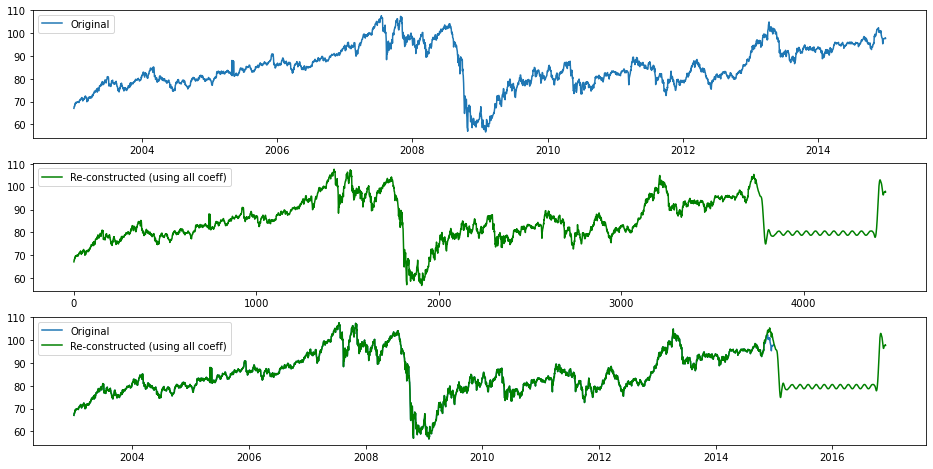

In [215]:
#print(predictedCoeff)
rpFs = imodwt(predictedCoeff,'sym4')
plotValues(dates, closing_prices ,rpFs, daysToPredict)

### Predicting using just the approximation coefficients

In [317]:
#past_days: Defines the number of days in the past to consider to do the prediction
#prediction_days: Defines the number of days in the future to predict
#file_Path: File Path which contains the data
#Delimiter: delimiter to split the data
#dateColName: Date column name
#closingPColName: Closing prices column name
def readData(past_days = 7, prediction_days = 5, file_Path = '../Data/AUD-JPY-2003-2014-day.csv', 
                        dateColName = 'Date', closingPColName = 'Close', delimiter = ';'):
    #Getting data from file
    dates, closing_prices = getDatesAndPrices(file_Path, dateColName, closingPColName, delimiter)

    return dates, closing_prices


def getApproxCoeffFromSeries(closing_prices):
    #calling function defined previously
    level = 4
    coeff = applyModwt(closing_prices,type='sym4',_level=level)
    return coeff

def trainModelApprox(X, Y, past_days):
    #Values needed to fully reconstruct the time series
    svr = svm.SVR(kernel ='rbf', C=1e3, gamma=0.1)
    svr.fit(X, Y)
    
    return svr



In [339]:
# getting dates and closing prices

daysToPredict = 7
past_days = 7
level = 4
dates, closing_prices = readData(past_days = past_days, prediction_days = daysToPredict)

In [341]:
# Getting approximation coefficients and last detail coefficients only
approxCoeff = getApproxCoeffFromSeries(closing_prices)

#initialize an array to store the coefficents corresponding to scale 2^4
recwt = np.zeros((np.shape(approxCoeff)[0], np.shape(approxCoeff)[1]))

#store coefficents corresponding to scale the 4 of the wavelet transformation
recwt[(level-1):] = approxCoeff[-2]
recwt[level:] = approxCoeff[-1]


#De-noised financial series. In this case we only use the aC to reconstruct the time series
dFs = imodwt(recwt,'sym4')


In [342]:
# training model using approx. coefficients
X, Y = slideWindow(dFs, past_days)

svr = trainModelApprox(X, Y, daysToPredict)

In [343]:
#Performing prediction
predictedValues = evaluateModel(svr, X, Y, prediction_days=daysToPredict, past_days=past_days) 

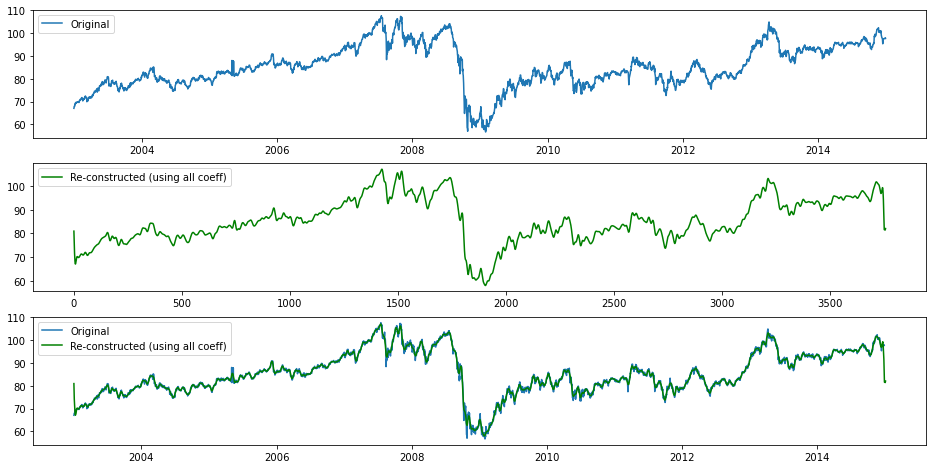

In [344]:
rpFs = np.concatenate((dFs, predictedValues[1:]))
#plotting values
plotValues(dates, closing_prices ,rpFs, daysToPredict)